In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('data/cleaned_student_lifestyle_dataset.csv')

In [3]:
df.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2,2.5-3
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,2,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4


Filter data to include only Low and High stress levels

In [10]:
df_filtered = df[df['stress_level'].isin(['Low', 'High'])]

In [11]:
df_filtered.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4
6,7,8.0,0.7,5.3,5.7,4.3,3.08,High,3,3-3.5
7,8,8.4,1.8,5.6,3.0,5.2,3.20,High,3,3-3.5


Define low and high stress groups

In [12]:
low_stress = df[df['stress_level'] == 'Low']['physical_activity_hours_per_day']
high_stress = df[df['stress_level'] == 'High']['physical_activity_hours_per_day']

Visual exploration of the groups

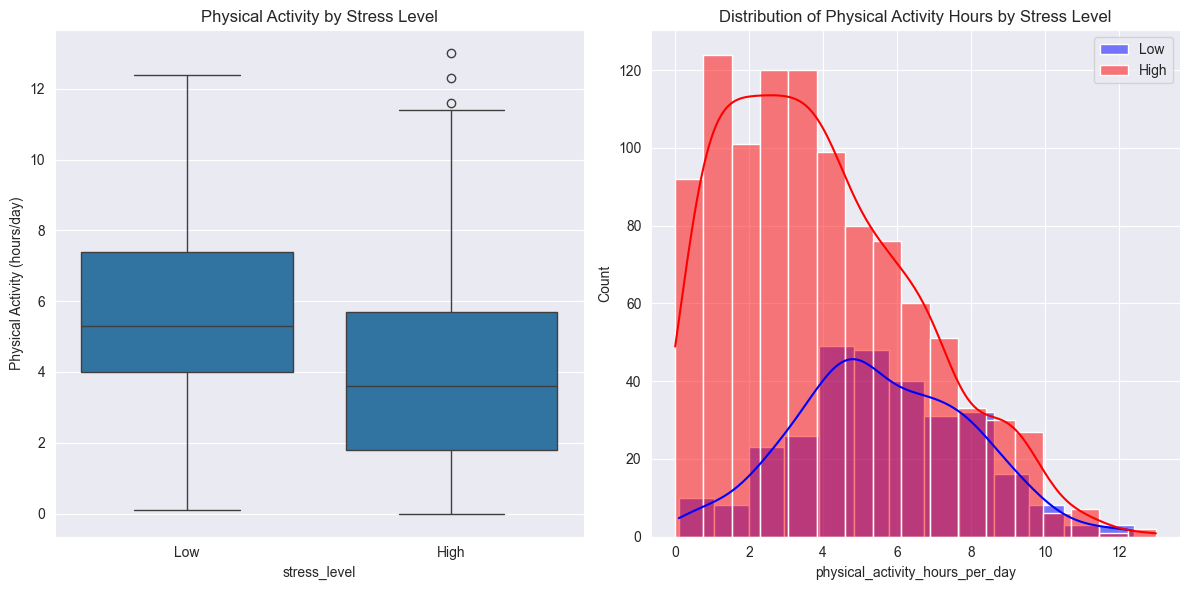

In [13]:
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='stress_level', y='physical_activity_hours_per_day', data=df_filtered)
plt.title('Physical Activity by Stress Level')
plt.ylabel('Physical Activity (hours/day)')

# Distribution
plt.subplot(1, 2, 2)
for group, color in zip(['Low', 'High'], ['blue', 'red']):
    sns.histplot(df[df['stress_level'] == group]['physical_activity_hours_per_day'],
                kde=True, label=group, color=color, alpha=0.5)
plt.title('Distribution of Physical Activity Hours by Stress Level')
plt.legend()
plt.tight_layout()
plt.show()